In [33]:
import os
# suppress silly log messages from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import importlib
import tensorflow as tf
import numpy as np
import random
import structure_prediction_utils as utils
from Autoencoder import AutoEncoder
# import resnet_model as res
import res_autoencoder as res
importlib.reload(res)
from tensorflow import keras

In [34]:
data_folder = './'
training_records = utils.load_preprocessed_data(data_folder, 'training.tfr')
validate_records = utils.load_preprocessed_data(data_folder, 'validation.tfr')
test_records = utils.load_preprocessed_data(data_folder, 'testing.tfr')

evolutionary shape= (5376,)
id shape= (1,)
primary shape= (256,)
tertiary shape= (256, 3)
primary_onehot shape= (256, 21)
mask shape= (256,)
true_distances shape= (256, 256)
distance_mask shape= (256, 256)
Value info of one data record, structure: tf.Tensor([1806.5  322.7 6882.9], shape=(3,), dtype=float32)
evolutionary shape= (5376,)
id shape= (1,)
primary shape= (256,)
tertiary shape= (256, 3)
primary_onehot shape= (256, 21)
mask shape= (256,)
true_distances shape= (256, 256)
distance_mask shape= (256, 256)
Value info of one data record, structure: tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)
evolutionary shape= (5376,)
id shape= (1,)
primary shape= (256,)
tertiary shape= (256, 3)
primary_onehot shape= (256, 21)
mask shape= (256,)
true_distances shape= (256, 256)
distance_mask shape= (256, 256)
Value info of one data record, structure: tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)


In [35]:
class ProteinStructurePredictor0(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer0 = keras.layers.Conv2D(5, 5, activation='gelu', padding="same")
        self.layer1 = keras.layers.Conv2D(1, 1, activation='gelu', padding="same")

    #@tf.function
    def call(self, inputs, mask=None):
        print("start call", '-'*20)
        primary_one_hot = inputs['primary_onehot']
        print(f"inputs x shape is: {primary_one_hot.shape}")
        # outer sum to get a NUM_RESIDUES x NUM_RESIDUES x embedding size
        x = tf.expand_dims(primary_one_hot, -2) + tf.expand_dims(primary_one_hot, -3)
        print(f"expand_dims x shape is: {x.shape}")

        # filter the initial representation into an embedded representation
        x = self.layer0(x)
        print(f"filter layer0 x shape is: {x.shape}")


        # add positional distance information
        r = tf.range(0, utils.NUM_RESIDUES, dtype=tf.float32)
        distances = tf.abs(tf.expand_dims(r, -1) - tf.expand_dims(r, -2))
        distances_bc = tf.expand_dims(
            tf.broadcast_to(distances, [primary_one_hot.shape[0], utils.NUM_RESIDUES, utils.NUM_RESIDUES]), -1)
        print(f"distances_bc shape is: {distances_bc.shape}")
        print(f"list of shape is {x.shape}  ,  {tf.shape(x * distances_bc)}  ,   {distances_bc.shape}")
        x = tf.concat([x, x * distances_bc, distances_bc], axis=-1)
        print(f"concat result x is {x.shape}")
        # x = distances_bc
        # generate result
        x = self.layer1(x)
        print(f"filter layer1 x shape is: {x.shape}")
        print("End call", '-'*20)
        return x

In [36]:
class ProteinStructurePredictor1(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer0 = keras.layers.Conv2D(5, 5, activation='gelu', padding="same")
        self.layer1 = keras.layers.Conv2D(1, 1, activation='gelu', padding="same")
        self.pooling = keras.layers.MaxPooling2D(pool_size=(8, 8))
        self.upsampling = keras.layers.UpSampling2D(size=(8, 8))
        self.attention = keras.layers.MultiHeadAttention(num_heads=1, key_dim=2)
        self.dense = keras.layers.Dense(64, activation='gelu')

    #@tf.function
    def call(self, inputs, mask=None):
        print("start call", '-'*20)
        primary_one_hot = inputs['primary_onehot']
        print(f"inputs x shape is: {primary_one_hot.shape}")
        # outer sum to get a NUM_RESIDUES x NUM_RESIDUES x embedding size
        x = tf.expand_dims(primary_one_hot, -2) + tf.expand_dims(primary_one_hot, -3)
        print(f"expand_dims x shape is: {x.shape}")

        # filter the initial representation into an embedded representation
        x = self.layer0(x)
        print(f"filter layer0 x shape is: {x.shape}")


        # add positional distance information
        r = tf.range(0, utils.NUM_RESIDUES, dtype=tf.float32)
        distances = tf.abs(tf.expand_dims(r, -1) - tf.expand_dims(r, -2))
        distances_bc = tf.expand_dims(
            tf.broadcast_to(distances, [primary_one_hot.shape[0], utils.NUM_RESIDUES, utils.NUM_RESIDUES]), -1)
        print(f"distances_bc shape is: {distances_bc.shape}")
        print(f"list of shape is {x.shape}  ,  {tf.shape(x * distances_bc)}  ,   {distances_bc.shape}")
        x = tf.concat([x, x * distances_bc, distances_bc], axis=-1)
        print(f"concat result x is {x.shape}")
        x = self.pooling(x)
        print(f'after pooling x shape is {x.shape}')
        attention_output = self.attention(x, x, x)
        print(f'attention_output shape is {attention_output.shape}')
        x = x + attention_output
        print(f"x + attention shape is {x.shape}")
        x = self.dense(x)
        print(f"x dense shape is {x.shape}")
        # x = distances_bc
        x = self.upsampling(x)
        print(f"after upsampling, x shape is: {x.shape}")
        # generate result
        x = self.layer1(x)
        print(f"filter layer1 x shape is: {x.shape}")
        print("End call", '-'*20)

        return x

In [37]:
class ProteinStructurePredictor2(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer0 = keras.layers.Conv2D(5, 5, activation='gelu', padding="same")
        self.layer1 = keras.layers.Conv2D(1, 1, activation='gelu', padding="same")
        self.pooling = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.upsampling = keras.layers.UpSampling2D(size=(2, 2))
        self.attention = keras.layers.MultiHeadAttention(num_heads=4, key_dim=16)
        self.dense = keras.layers.Dense(64, activation='gelu')

    #@tf.function
    def call(self, inputs, mask=None):
        print("start call", '-'*20)
        primary_one_hot = inputs['primary_onehot']
        print(f'primary_one_hot shape is {primary_one_hot.shape}')
        attention_output = self.attention(primary_one_hot, primary_one_hot, primary_one_hot)
        print(f'attention_output shape is {attention_output.shape}')
        x = primary_one_hot + attention_output
        print(f"x + attention shape is {x.shape}")
        # outer sum to get a NUM_RESIDUES x NUM_RESIDUES x embedding size
        x = tf.expand_dims(primary_one_hot, -2) + tf.expand_dims(primary_one_hot, -3)
        print(f"expand_dims x shape is: {x.shape}")

        # filter the initial representation into an embedded representation
        x = self.layer0(x)
        print(f"filter layer0 x shape is: {x.shape}")


        # add positional distance information
        r = tf.range(0, utils.NUM_RESIDUES, dtype=tf.float32)
        distances = tf.abs(tf.expand_dims(r, -1) - tf.expand_dims(r, -2))
        distances_bc = tf.expand_dims(
            tf.broadcast_to(distances, [primary_one_hot.shape[0], utils.NUM_RESIDUES, utils.NUM_RESIDUES]), -1)
        print(f"distances_bc shape is: {distances_bc.shape}")
        print(f"list of shape is {x.shape}  ,  {tf.shape(x * distances_bc)}  ,   {distances_bc.shape}")
        x = tf.concat([x, x * distances_bc, distances_bc], axis=-1)
        print(f"concat result x is {x.shape}")
        x = self.pooling(x)
        print(f'after pooling x shape is {x.shape}')
        x = self.dense(x)
        print(f"x dense shape is {x.shape}")
        # x = distances_bc
        x = self.upsampling(x)
        print(f"after upsampling, x shape is: {x.shape}")
        # generate result
        x = self.layer1(x)
        print(f"filter layer1 x shape is: {x.shape}")
        print("End call", '-'*20)

        return x

In [38]:
# import tensorflow as tf
# import numpy as np

# class Encoder(tf.keras.layers.Layer):
#     def __init__(self):
#        super(Encoder, self).__init__()
#        self.encoder_conv_1 = tf.keras.layers.Conv2D(
#            filters=8,
#            kernel_size=3,
#            strides=2,
#            padding='same',
#            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#            activation=tf.keras.layers.LeakyReLU(alpha=0.2)
#        )
#        self.encoder_conv_2 = tf.keras.layers.Conv2D(
#            filters=16,
#            kernel_size=3,
#            strides=2,
#            padding='same',
#            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#            activation=tf.keras.layers.LeakyReLU(alpha=0.2)
#        )
#        self.encoder_conv_3 = tf.keras.layers.Conv2D(
#            filters=32,
#            kernel_size=3,
#            strides=2,
#            padding='same',
#            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#            activation=tf.keras.layers.LeakyReLU(alpha=0.2)
#        )

#     @tf.function
#     def call(self, images):
#       x = self.encoder_conv_1(images)
#       x = self.encoder_conv_2(x)
#       x = self.encoder_conv_3(x)
#       return x
    
# class Decoder(tf.keras.layers.Layer):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.decoder_deconv_1 = tf.keras.layers.Conv2DTranspose(
#             filters=16,
#             kernel_size=3,
#             strides=2,
#             padding='same',
#             kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#             activation=tf.keras.layers.LeakyReLU(alpha=0.2)
#         )
#         self.decoder_deconv_2 = tf.keras.layers.Conv2DTranspose(
#             filters=8,
#             kernel_size=3,
#             strides=2,
#             padding='same',
#             kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#             activation=tf.keras.layers.LeakyReLU(alpha=0.2)
#         )
#         self.decoder_deconv_3 = tf.keras.layers.Conv2DTranspose(
#             filters=3,
#             kernel_size=3,
#             strides=2,
#             padding='same',
#             kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#             activation=tf.keras.layers.LeakyReLU(alpha=0.2)
#         )
#     @tf.function
#     def call(self, encoder_output):
#       x = self.decoder_deconv_1(encoder_output)
#       x = self.decoder_deconv_2(x)
#       x = self.decoder_deconv_3(x)
#       return x
    
# class AutoEncoder(tf.keras.Model):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()

#     @tf.function
#     def call(self, inputs):
#       encoded = self.encoder(inputs)
#       decoded = self.decoder(encoded)
#       return decoded

In [39]:
class ProteinStructurePredictor4(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer0 = keras.layers.Conv2D(5, 5, activation='gelu', padding="same")
        self.layer1 = keras.layers.Conv2D(1, 1, activation='gelu', padding="same")
        self.pooling = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.upsampling = keras.layers.UpSampling2D(size=(2, 2))
        self.attention = keras.layers.MultiHeadAttention(num_heads=4, key_dim=16)
        self.dense = keras.layers.Dense(64, activation='gelu')
        # self.encoder = Encoder()
        # self.decoder = Decoder()
        self.autencode = AutoEncoder()
        self.resnet = res.resnet50()

    #@tf.function
    def call(self, inputs, mask=None):
        print("start call", '-'*20)
        primary_one_hot = inputs['primary_onehot']
        print(f'primary_one_hot shape is {primary_one_hot.shape}')
        attention_output = self.attention(primary_one_hot, primary_one_hot, primary_one_hot)
        print(f'attention_output shape is {attention_output.shape}')
        x = primary_one_hot + attention_output
        print(f"x + attention shape is {x.shape}")
        # outer sum to get a NUM_RESIDUES x NUM_RESIDUES x embedding size
        x = tf.expand_dims(primary_one_hot, -2) + tf.expand_dims(primary_one_hot, -3)
        print(f"expand_dims x shape is: {x.shape}")

        x = self.resnet(x)
        print(f"After resnet x shape is: {x.shape}")
        # filter the initial representation into an embedded representation
        x = self.layer0(x)
        print(f"filter layer0 x shape is: {x.shape}")


        # add positional distance information
        r = tf.range(0, utils.NUM_RESIDUES, dtype=tf.float32)
        distances = tf.abs(tf.expand_dims(r, -1) - tf.expand_dims(r, -2))
        distances_bc = tf.expand_dims(
            tf.broadcast_to(distances, [primary_one_hot.shape[0], utils.NUM_RESIDUES, utils.NUM_RESIDUES]), -1)
        print(f"distances_bc shape is: {distances_bc.shape}")
        print(f"list of shape is {x.shape}  ,  {tf.shape(x * distances_bc)}  ,   {distances_bc.shape}")
        x = tf.concat([x, x * distances_bc, distances_bc], axis=-1)
        print(f"concat result x is {x.shape}")
        x = self.pooling(x)
        print(f'after pooling x shape is {x.shape}')
        x = self.dense(x)
        print(f"x dense shape is {x.shape}")
        # x = self.encoder(x)
        # print(f'after encoder shape is {x.shape}')
        # x = self.decoder(x)
        # print(f'after decoder shape is {x.shape}')
        x = self.autencode(x)
        print(f'autencode shape is {x.shape}')
        # x = distances_bc
        x = self.upsampling(x)
        print(f"after upsampling, x shape is: {x.shape}")
        # generate result
        x = self.layer1(x)
        print(f"filter layer1 x shape is: {x.shape}")
        print("End call", '-'*20)

        return x

In [40]:
class ProteinStructurePredictor5(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer0 = keras.layers.Conv2D(5, 5, activation='gelu', padding="same")
        self.layer1 = keras.layers.Conv2D(1, 1, activation='gelu', padding="same")
        self.attention = keras.layers.MultiHeadAttention(num_heads=4, key_dim=16)
        self.dense = keras.layers.Dense(64, activation='gelu')
        self.resnet = res.resnet34()
        self.add = keras.layers.Add()

    #@tf.function
    def call(self, inputs, mask=None):
        print(f"mask shape is {mask.shape}")
        print("start call", '-'*20)
        primary_one_hot = inputs['primary_onehot']
        print(f'primary_one_hot shape is {primary_one_hot.shape}')
        attention_output = self.attention(primary_one_hot, primary_one_hot, primary_one_hot)
        print(f'attention_output shape is {attention_output.shape}')
        x = self.add([primary_one_hot , attention_output])
        print(f"x +  add attention shape is {x.shape}")
        x = self.dense(x)
        print(f"x dense shape is {x.shape}")
        # outer sum to get a NUM_RESIDUES x NUM_RESIDUES x embedding size
        x = tf.expand_dims(x, -2) + tf.expand_dims(x, -3)
        print(f"expand_dims x shape is: {x.shape}")
        # filter the initial representation into an embedded representation
        x = self.layer0(x)
        print(f"filter layer0 x shape is: {x.shape}")
        # add positional distance information
        r = tf.range(0, utils.NUM_RESIDUES, dtype=tf.float32)
        distances = tf.abs(tf.expand_dims(r, -1) - tf.expand_dims(r, -2))
        distances_bc = tf.expand_dims(
            tf.broadcast_to(distances, [primary_one_hot.shape[0], utils.NUM_RESIDUES, utils.NUM_RESIDUES]), -1)
        print(f"distances_bc shape is: {distances_bc.shape}")
        print(f"list of shape is {x.shape}  ,  {tf.shape(x * distances_bc)}  ,   {distances_bc.shape}")
        distances_bc = distances_bc * tf.expand_dims(mask, axis=-1)
        x = tf.concat([x, x * distances_bc, distances_bc], axis=-1)
        print(f"concat result x is {x.shape}")
        x = self.resnet(x)
        print(f"After resnet x shape is: {x.shape}")
        x = self.layer1(x)
        print(f"filter layer1 x shape is: {x.shape}")
        print("End call", '-'*20)

        return x
    


In [41]:
model = ProteinStructurePredictor5()
model.optimizer = keras.optimizers.Adam(learning_rate=1e-2)
model.batch_size = 1
epochs = 5
def get_n_records(batch):
    return batch['primary_onehot'].shape[0]
def get_input_output_masks(batch):
    inputs = {'primary_onehot':batch['primary_onehot']}
    outputs = batch['true_distances']
    masks = batch['distance_mask']
    return inputs, outputs, masks

In [42]:
epoch_training_records = training_records.shuffle(buffer_size=256).batch(model.batch_size, drop_remainder=False)
train_loss=utils.mse_loss
for batch in epoch_training_records:
    inputs, labels, masks = get_input_output_masks(batch)
    print(labels[0][0])
    with tf.GradientTape() as tape:
        print(inputs['primary_onehot'].shape,labels.shape,masks.shape)
        outputs = model(inputs, masks)
        l = train_loss(outputs, labels, masks)
        batch_loss = tf.reduce_sum(l)
        break

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(256,), dtype=float32)
(1, 256, 21) (1, 256, 256) (1, 256, 256)
mask shape is (1, 256, 256)
start call --------------------
primary_one_hot shape is (1, 256, 21)
attention_output shape is (1, 256, 21)
x

In [43]:
import tensorflow as tf

# 查看所有物理 GPU 设备
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[  0.          42.10526316  84.21052632 126.31578947 168.42105263
 210.52631579 252.63157895 294.73684211 336.84210526 378.94736842
 421.05263158 463.15789474 505.26315789 547.36842105 589.47368421
 631.57894737 673.68421053 715.78947368 757.89473684 800.        ]


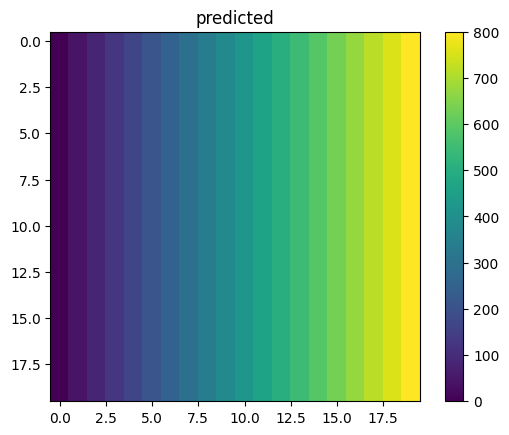

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# 创建一个 (20, 20, 1) 的矩阵，左边为 -10，右边为 10
x = np.linspace(0, 800, 20)
print(x)
dist1 = np.tile(x, (20, 1, 1))

# squeeze 去掉最后的维度
dist1_squeezed = np.squeeze(dist1)

f, axarr = plt.subplots(1, 1)
axarr.set_title('predicted')
im1 = axarr.imshow(dist1_squeezed)
f.colorbar(im1, ax=axarr)
plt.show()


In [52]:
import numpy as np
import matplotlib.pyplot as plt

# 创建一个 (20, 20, 1) 的矩阵，左边为 -10，右边为 10
# x = np.linspace(0, 800, 20)
# print(x)
# dist1 = np.tile(x, (20, 1, 1))

dist1 = tf.squeeze(labels) * masks
tensor_numpy = masks.numpy()


# squeeze 去掉最后的维度
dist1_squeezed = np.squeeze(dist1)

f, axarr = plt.subplots(1, 1)
axarr.set_title('predicted')
im1 = axarr.imshow(dist1_squeezed)
f.colorbar(im1, ax=axarr)
plt.show()

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
   0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
   1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 